In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_274921/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
sys.executable

'/home/joz608/.conda/envs/grc/bin/python3.8'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
# %matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
# base_dir = '/n/data1/hms/neurobio/sabatini/josh'

In [5]:
import sys

# base_dir = '/Users/josh/Documents'
base_dir = '../../../..'
sys.path.append(f'{base_dir}/github_repos')
# data_folder = f'../../data/final'
data_folder = f'../../data/training'
simclr_model_folder = f'../../models/simclr-modelsn'
model_performance_folder = f'../../reports/model-performance'
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition

# Must "pip install -e . in root project directory for this to work"
from GCaMP_ROI_classifier import util, dataset, models, training, augmentation

In [6]:
# !pip install numba
# !pip install copy
# !pip install scipy


## Import unlabeled training data

In [7]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [8]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

data_labeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_unbalanced.h5')

masks_SYT = data_labeled['SYTmasks']
labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
labels_SYT = labels_SYT[non_nan]
masks_SYT = masks_SYT[non_nan]

X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [9]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


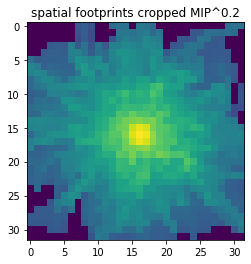

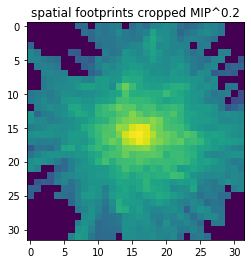

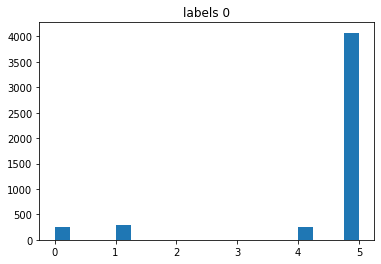

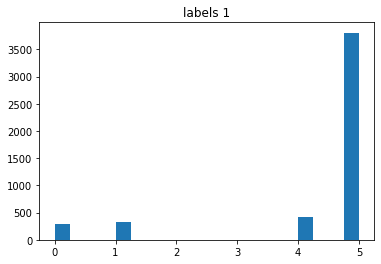

In [10]:
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

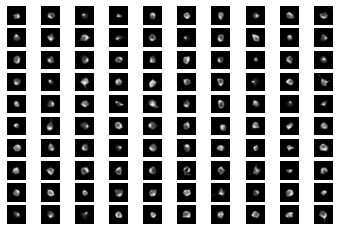

In [11]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [12]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [13]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [14]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

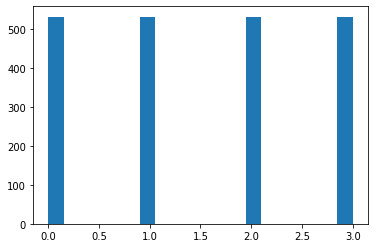

In [15]:
plt.figure()
plt.hist(labels_dup, 20);

In [16]:
images.shape

(2128, 32, 32)

# Train

In [17]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cuda'


### Define New model = model + pre-head + latent layer OR classification layer

In [18]:
# class ModelTackOn(torch.nn.Module):
#     def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
#             super(ModelTackOn, self).__init__()
#             self.base_model = base_model
#             final_base_layer = list(un_modified_model.children())[-1]
#             # final_base_layer = list(list(model.children())[-1].children())[-1]
#             # print(final_base_layer)

#             self.pre_head_fc_lst = []
#             self.post_head_fc_lst = []
#             self.classifier_fc_lst = []

#             self.init_prehead(final_base_layer, pre_head_fc_sizes)
#             self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
#             if classifier_fc_sizes is not None:
#                 self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
#     def init_prehead(self, prv_layer, pre_head_fc_sizes):
#         for i, pre_head_fc in enumerate(pre_head_fc_sizes):
#             if i == 0:
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
#             else:
#                 in_features = pre_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
#             self.add_module(f'PreHead_{i}', fc_layer)
#             self.pre_head_fc_lst.append(fc_layer)

# #             if i < len(pre_head_fc_sizes) - 1:
#             non_linearity = torch.nn.ReLU()
#             self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
#             self.pre_head_fc_lst.append(non_linearity)

#     def init_posthead(self, prv_size, post_head_fc_sizes):
#         for i, post_head_fc in enumerate(post_head_fc_sizes):
#             if i == 0:
#                 in_features = prv_size
#             else:
#                 in_features = post_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
#             self.add_module(f'PostHead_{i}', fc_layer)
#             self.post_head_fc_lst.append(fc_layer)

#             if i < len(post_head_fc_sizes) - 1:
#                 non_linearity = torch.nn.ReLU()
#                 self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
#                 self.pre_head_fc_lst.append(non_linearity)
    
#     def init_classifier(self, prv_size, classifier_fc_sizes):
#             for i, classifier_fc in enumerate(classifier_fc_sizes):
#                 if i == 0:
#                     in_features = prv_size
#                 else:
#                     in_features = classifier_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
#             self.add_module(f'Classifier_{i}', fc_layer)
#             self.classifier_fc_lst.append(fc_layer)

#     def reinit_classifier(self):
#         for i_layer, layer in enumerate(self.classifier_fc_lst):
#             layer.reset_parameters()
    
# #     def forward(self, X):
# #         interim = self.base_model(X)
# #         interim = self.get_head(interim)
# #         interim = self.get_latent(interim)
# #         return interim

#     def forward_classifier(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.classify(interim)
#         return interim

#     def forward_latent(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim


#     def get_head(self, base_out):
#         # print('base_out', base_out.shape)
#         head = base_out
#         for pre_head_layer in self.pre_head_fc_lst:
#           # print('pre_head_layer', pre_head_layer.in_features)
#           head = pre_head_layer(head)
#           # print('head', head.shape)
#         return head

#     def get_latent(self, head):
#         latent = head
#         for post_head_layer in self.post_head_fc_lst:
#             latent = post_head_layer(latent)
#         return latent

#     def classify(self, head):
#         logit = head
#         for classifier_layer in self.classifier_fc_lst:
#             logit = classifier_layer(logit)
#         return logit

#     def set_pre_head_grad(self, requires_grad=True):
#         for layer in self.pre_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad
                
#     def set_post_head_grad(self, requires_grad=True):
#         for layer in self.post_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def set_classifier_grad(self, requires_grad=True):
#         for layer in self.classifier_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def prep_contrast(self):
#         self.set_pre_head_grad(requires_grad=True)
#         self.set_post_head_grad(requires_grad=True)
#         self.set_classifier_grad(requires_grad=False)

#     def prep_classifier(self):
#         self.set_pre_head_grad(requires_grad=False)
#         self.set_post_head_grad(requires_grad=False)
#         self.set_classifier_grad(requires_grad=True)


In [19]:
from GCaMP_ROI_classifier.vicreg import main_vicreg as mvr
from GCaMP_ROI_classifier.vicreg.main_vicreg import *
from GCaMP_ROI_classifier.vicreg import augmentations as vraug

In [20]:
from pathlib import Path
import argparse
import json
import math
import os
import sys
import time

import torch
import torch.nn.functional as F
from torch import nn, optim
import torch.distributed as dist
import torchvision.datasets as datasets

import GCaMP_ROI_classifier.vicreg.augmentations as aug
from GCaMP_ROI_classifier.vicreg.distributed import init_distributed_mode

import GCaMP_ROI_classifier.vicreg.resnet

parser = argparse.ArgumentParser('VICReg training script', parents=[mvr.get_arguments()])
args = parser.parse_args(['--device', 'cuda',
                          '--data-dir', '../../data',
                          '--exp-dir', '../../models/vicreg-models/fullaug3',
                          '--batch-size', '800',
                          '--arch', 'resnet18',
                          '--mlp', '512-512-512'
                         ])
args.rank = args.local_rank


In [21]:
args.batch_size

800

In [22]:
from GCaMP_ROI_classifier.dataset import dataset_vicreg

In [23]:
# import torchvision.transforms    

# transforms = torch.nn.Sequential(
#     # torchvision.transforms.RandomHorizontalFlip(p=0.5),    
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
#     augmentation.WarpPoints(r=[0, 1],
#                             cx=[-0.5, 0.5],
#                             cy=[-0.5, 0.5], 
#                             dx=[-0.3, 0.0], 
#                             dy=[-0.3, 0.0], 
#                             n_warps=5,
#                             prob=1.0,
#                             img_size_in=[36, 36],
#                             img_size_out=[224, 224]),

    
#     augmentation.TileChannels(dim=0, n_channels=3),
# #     torchvision.transforms.Resize(size=(224,224), 
# #                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
# )
    

# scripted_transforms = torch.jit.script(transforms)


import torchvision.transforms    

transforms = torch.nn.Sequential(
#     augmentation.Horizontal_stripe_scale(alpha_min_max=(0.5,1), im_size=(36,36), p=0.25),
#     augmentation.Horizontal_stripe_shift(alpha_min_max=(0,6), im_size=(36,36), p=0.25),
    
    torchvision.transforms.RandomHorizontalFlip(p=0.5),    
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
                                        scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
                                        shear=(-15, 15, -15, 15),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
                                    scaler_bounds=(10**(4), 10**(6)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.00015,
                                    prob=1),
    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
#     augmentation.WarpPoints(r=[0, 1],
#                             cx=[-0.5, 0.5], 
#                             cy=[-0.5, 0.5], 
#                             dx=[-0.3, 0.0], 
#                             dy=[-0.3, 0.0], 
#                             n_warps=2,
#                             prob=1.0,
#                             img_size_in=[36, 36],
#                             img_size_out=[224, 224]),
    
#     vraug.Solarize(p=0),
#     augmentation.Horizontal_stripe_scale(alpha_min_max=(0.5,1), im_size=(36,36), p=0.25),
#     augmentation.Horizontal_stripe_shift(alpha_min_max=(0,6), im_size=(36,36), p=0.25),
    
    augmentation.TileChannels(dim=0, n_channels=3),
    
)
    

scripted_transforms = torch.jit.script(transforms)

In [26]:
# args.rank, args.world_size

In [27]:
# import os
# import sys
# import tempfile
# import torch
# import torch.distributed as dist
# import torch.nn as nn
# import torch.optim as optim
# import torch.multiprocessing as mp

# from torch.nn.parallel import DistributedDataParallel as DDP

# def setup(rank, world_size):
#     os.environ['MASTER_ADDR'] = 'localhost'
#     os.environ['MASTER_PORT'] = '12355'

#     # initialize the process group
#     dist.init_process_group("gloo", rank=rank, world_size=world_size)

# def cleanup():
#     dist.destroy_process_group()

# setup(args.rank, args.world_size)

In [28]:
# args.rank = args.local_rank
args.rank = 0

In [29]:
masks_cat.shape[0]//args.batch_size+1

890

In [30]:
from tqdm.notebook import tqdm, trange

torch.backends.cudnn.benchmark = True
# mvr.init_distributed_mode(args)
print(args)
gpu = torch.device(args.device)

if args.rank == 0:
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    stats_file = open(args.exp_dir / "stats.txt", "a", buffering=1)
    print(" ".join(sys.argv))
    print(" ".join(sys.argv), file=stats_file)

# transforms = aug.TrainTransform()

dataset = dataset_vicreg(
                                torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms, scripted_transforms],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
# dataset = datasets.ImageFolder(args.data_dir / "training", transforms)
# sampler = torch.utils.data.distributed.DistributedSampler(dataset, shuffle=True)
sampler = torch.utils.data.RandomSampler(dataset)
assert args.batch_size % args.world_size == 0
per_device_batch_size = args.batch_size // args.world_size
# loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=per_device_batch_size,
# #     num_workers=args.num_workers,
# #     pin_memory=True,
#     sampler=sampler,
# )

loader = torch.utils.data.DataLoader( dataset,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                # shuffle=True,
                                                shuffle=True,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=15,
                                                persistent_workers=True,
                                                prefetch_factor=3
                                                )

model = mvr.VICReg(args).to(DEVICE)#cuda(gpu)
# model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
# model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])

Namespace(arch='resnet18', base_lr=0.2, batch_size=800, cov_coeff=1.0, data_dir=PosixPath('../../data'), device='cuda', dist_url='env://', epochs=100, exp_dir=PosixPath('../../models/vicreg-models/fullaug3'), local_rank=-1, log_freq_time=60, mlp='512-512-512', num_workers=10, out_features='512', rank=0, sim_coeff=25.0, std_coeff=25.0, wd=1e-06, world_size=1)
/home/joz608/.conda/envs/grc/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joz608/.local/share/jupyter/runtime/kernel-cdd92b19-41ee-4210-8d4b-de5a1050e456.json
0.weight
1.weight
1.bias
4.0.conv1.weight
4.0.bn1.weight
4.0.bn1.bias
4.0.conv2.weight
4.0.bn2.weight
4.0.bn2.bias
4.1.conv1.weight
4.1.bn1.weight
4.1.bn1.bias
4.1.conv2.weight
4.1.bn2.weight
4.1.bn2.bias
5.0.conv1.weight
5.0.bn1.weight
5.0.bn1.bias
5.0.conv2.weight
5.0.bn2.weight
5.0.bn2.bias
5.0.downsample.0.weight
5.0.downsample.1.weight
5.0.downsample.1.bias
5.1.conv1.weight
5.1.bn1.weight
5.1.bn1.bias
5.1.conv2.weight
5.1.bn2.weight
5.1.bn2.bias
6.0.conv1.w

In [31]:
dataset[ii][0].shape

torch.Size([3, 36, 36])

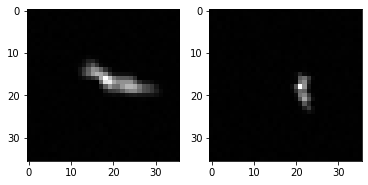

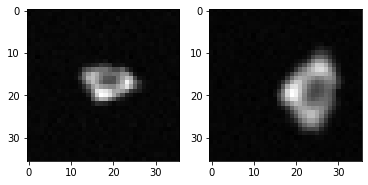

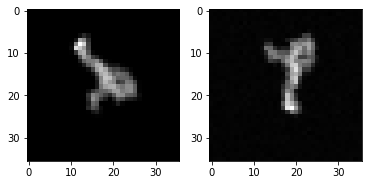

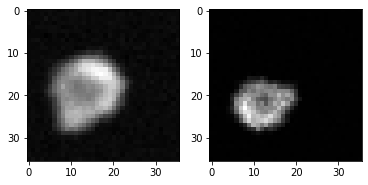

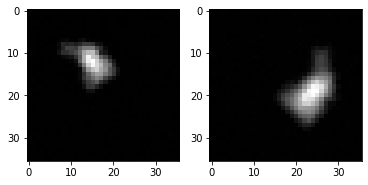

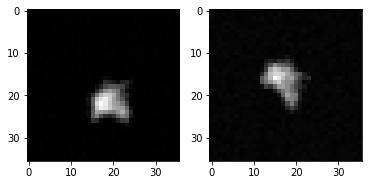

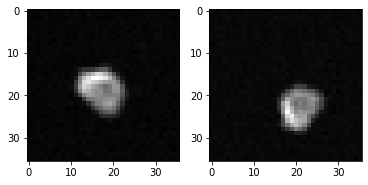

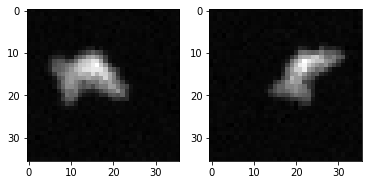

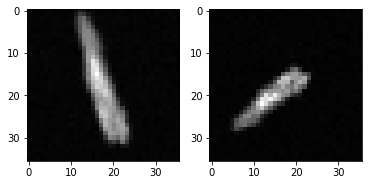

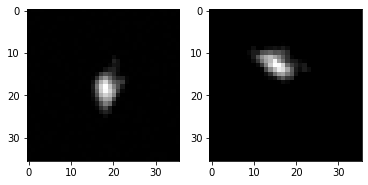

In [32]:
idx_rand = np.random.randint(0,len(dataset), 10)
for ii in idx_rand:
    fig, axs = plt.subplots(1,2)
    # print(dataset_train[ii][0][0][0].shape)
    axs[0].imshow(np.transpose(dataset[ii][0], [1,2,0]))
    axs[1].imshow(np.transpose(dataset[ii][1], [1,2,0]))

In [33]:
optimizer = mvr.LARS(
    model.parameters(),
    lr=0,
    weight_decay=args.wd,
    weight_decay_filter=exclude_bias_and_norm,
    lars_adaptation_filter=exclude_bias_and_norm,
)

if (args.exp_dir / "model.pth").is_file():
    if args.rank == 0:
        print("resuming from checkpoint")
    ckpt = torch.load(args.exp_dir / "model.pth", map_location="cpu")
    start_epoch = ckpt["epoch"]
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
else:
    start_epoch = 0

resuming from checkpoint


In [32]:
start_time = last_logging = time.time()
scaler = torch.cuda.amp.GradScaler()
for epoch in trange(start_epoch, args.epochs):
#     sampler.set_epoch(epoch)
#     for step, ((x, y), _) in enumerate(loader, start=epoch * len(loader)):
    for step, (x, y, _) in tqdm(enumerate(loader, start=epoch * len(loader)), total=len(loader)+1):
        x = x.cuda(gpu, non_blocking=True)
        y = y.cuda(gpu, non_blocking=True)
#         x = x.to(DEVICE)
#         y = y.to(DEVICE)

        lr = mvr.adjust_learning_rate(args, optimizer, loader, step)

        optimizer.zero_grad()
#         with torch.cuda.amp.autocast():
        loss = model.forward(x, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        current_time = time.time()
        if args.rank == 0 and current_time - last_logging > args.log_freq_time:
            stats = dict(
                epoch=epoch,
                step=step,
                loss=loss.item(),
                time=int(current_time - start_time),
                lr=lr,
            )
            print(json.dumps(stats))
            print(json.dumps(stats), file=stats_file)
            last_logging = current_time
    if args.rank == 0:
        state = dict(
            epoch=epoch + 1,
            model=model.state_dict(),
            optimizer=optimizer.state_dict(),
        )
        torch.save(state, args.exp_dir / "model.pth")
if args.rank == 0:
    torch.save(model.module.backbone.state_dict(), args.exp_dir / "resnet18.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 0, "step": 418, "loss": 17.178916931152344, "time": 60, "lr": 0.029353932584269663}
{"epoch": 0, "step": 879, "loss": 15.529350280761719, "time": 120, "lr": 0.06172752808988764}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 1, "step": 1319, "loss": 14.80754280090332, "time": 180, "lr": 0.09262640449438202}
{"epoch": 1, "step": 1779, "loss": 13.266146659851074, "time": 240, "lr": 0.12492977528089888}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 2, "step": 2226, "loss": 13.847776412963867, "time": 300, "lr": 0.15632022471910112}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 3, "step": 2674, "loss": 13.434347152709961, "time": 360, "lr": 0.1877808988764045}
{"epoch": 3, "step": 3133, "loss": 12.60252571105957, "time": 420, "lr": 0.22001404494382024}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 4, "step": 3580, "loss": 12.317607879638672, "time": 480, "lr": 0.25140449438202245}
{"epoch": 4, "step": 4040, "loss": 12.067445755004883, "time": 540, "lr": 0.28370786516853935}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 5, "step": 4488, "loss": 11.547284126281738, "time": 600, "lr": 0.3151685393258427}
{"epoch": 5, "step": 4947, "loss": 11.375782012939453, "time": 660, "lr": 0.34740168539325844}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 6, "step": 5394, "loss": 11.344026565551758, "time": 720, "lr": 0.3787921348314607}
{"epoch": 6, "step": 5852, "loss": 11.136329650878906, "time": 780, "lr": 0.4109550561797753}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 7, "step": 6297, "loss": 10.610796928405762, "time": 840, "lr": 0.4422050561797753}
{"epoch": 7, "step": 6757, "loss": 10.527901649475098, "time": 900, "lr": 0.47450842696629214}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 8, "step": 7203, "loss": 10.177938461303711, "time": 960, "lr": 0.5058286516853933}
{"epoch": 8, "step": 7661, "loss": 10.203409194946289, "time": 1020, "lr": 0.5379915730337078}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 9, "step": 8107, "loss": 9.693437576293945, "time": 1080, "lr": 0.5693117977528089}
{"epoch": 9, "step": 8567, "loss": 9.84432601928711, "time": 1140, "lr": 0.6016151685393258}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 10, "step": 9015, "loss": 9.643991470336914, "time": 1201, "lr": 0.6249968244776635}
{"epoch": 10, "step": 9475, "loss": 9.459514617919922, "time": 1261, "lr": 0.6249206151716316}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 11, "step": 9923, "loss": 9.206525802612305, "time": 1321, "lr": 0.6247487458570447}
{"epoch": 11, "step": 10383, "loss": 8.652360916137695, "time": 1381, "lr": 0.6244720654473215}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 12, "step": 10829, "loss": 9.469334602355957, "time": 1441, "lr": 0.6241069464223823}
{"epoch": 12, "step": 11290, "loss": 8.746931076049805, "time": 1501, "lr": 0.6236294401621383}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 13, "step": 11740, "loss": 8.932209014892578, "time": 1561, "lr": 0.6230653258359833}
{"epoch": 13, "step": 12201, "loss": 8.916601181030273, "time": 1621, "lr": 0.6223872097037095}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 14, "step": 12648, "loss": 8.173847198486328, "time": 1681, "lr": 0.6216330458942216}
{"epoch": 14, "step": 13108, "loss": 8.265499114990234, "time": 1741, "lr": 0.6207578534767446}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 15, "step": 13555, "loss": 8.10971736907959, "time": 1801, "lr": 0.6198113676123432}
{"epoch": 15, "step": 14015, "loss": 7.819169044494629, "time": 1861, "lr": 0.6187388450398184}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 16, "step": 14464, "loss": 8.017399787902832, "time": 1921, "lr": 0.6175959339779808}
{"epoch": 16, "step": 14924, "loss": 7.896769046783447, "time": 1981, "lr": 0.6163270078925233}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 17, "step": 15372, "loss": 7.8413166999816895, "time": 2041, "lr": 0.6149962215477287}
{"epoch": 17, "step": 15832, "loss": 7.40289306640625, "time": 2101, "lr": 0.6135327179608264}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 18, "step": 16280, "loss": 7.749144077301025, "time": 2161, "lr": 0.6120133037570138}
{"epoch": 18, "step": 16738, "loss": 7.627324104309082, "time": 2221, "lr": 0.610364489572387}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 19, "step": 17185, "loss": 7.278424263000488, "time": 2282, "lr": 0.6086626925466785}
{"epoch": 19, "step": 17644, "loss": 7.291559219360352, "time": 2342, "lr": 0.606820589666658}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 20, "step": 18093, "loss": 7.476907730102539, "time": 2402, "lr": 0.6049264252539391}
{"epoch": 20, "step": 18554, "loss": 7.333130359649658, "time": 2462, "lr": 0.6028873914784064}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 21, "step": 19002, "loss": 7.0419745445251465, "time": 2522, "lr": 0.6008149971780244}
{"epoch": 21, "step": 19463, "loss": 7.203526973724365, "time": 2582, "lr": 0.598589650319303}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 22, "step": 19911, "loss": 7.496084213256836, "time": 2642, "lr": 0.5963375424312818}
{"epoch": 22, "step": 20371, "loss": 7.0400824546813965, "time": 2702, "lr": 0.5939340356948082}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 23, "step": 20818, "loss": 7.135478973388672, "time": 2762, "lr": 0.5915107868081694}
{"epoch": 23, "step": 21276, "loss": 7.161245346069336, "time": 2822, "lr": 0.5889390650724091}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 24, "step": 21721, "loss": 6.876701831817627, "time": 2882, "lr": 0.5863549928078347}
{"epoch": 24, "step": 22180, "loss": 6.875635147094727, "time": 2942, "lr": 0.5836023356893619}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 25, "step": 22628, "loss": 6.838977336883545, "time": 3002, "lr": 0.5808310120213068}
{"epoch": 25, "step": 23086, "loss": 7.093408584594727, "time": 3062, "lr": 0.5779122985739696}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 26, "step": 23534, "loss": 7.060990810394287, "time": 3123, "lr": 0.5749745479729649}
{"epoch": 26, "step": 23994, "loss": 6.560118675231934, "time": 3183, "lr": 0.5718738978146182}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 27, "step": 24442, "loss": 6.698590278625488, "time": 3243, "lr": 0.5687730743653434}
{"epoch": 27, "step": 24901, "loss": 6.865085124969482, "time": 3303, "lr": 0.5655141658072734}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 28, "step": 25349, "loss": 6.4686689376831055, "time": 3363, "lr": 0.5622543747550359}
{"epoch": 28, "step": 25808, "loss": 6.519070625305176, "time": 3423, "lr": 0.5588346830343104}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 29, "step": 26255, "loss": 6.493055820465088, "time": 3483, "lr": 0.5554277548423481}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 30, "step": 26704, "loss": 6.537431716918945, "time": 3543, "lr": 0.5519305147853875}
{"epoch": 30, "step": 27164, "loss": 6.80242919921875, "time": 3603, "lr": 0.5482707053675284}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 31, "step": 27610, "loss": 6.294393539428711, "time": 3663, "lr": 0.5446490935398712}
{"epoch": 31, "step": 28070, "loss": 6.716738700866699, "time": 3723, "lr": 0.5408394986934697}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 32, "step": 28516, "loss": 6.43868350982666, "time": 3783, "lr": 0.5370749691436096}
{"epoch": 32, "step": 28975, "loss": 6.582947731018066, "time": 3843, "lr": 0.5331290737747167}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 33, "step": 29421, "loss": 6.353693008422852, "time": 3904, "lr": 0.5292265291897762}
{"epoch": 33, "step": 29880, "loss": 6.985589504241943, "time": 3964, "lr": 0.5251411038332768}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 34, "step": 30327, "loss": 6.360937118530273, "time": 4024, "lr": 0.5210963398621934}
{"epoch": 34, "step": 30788, "loss": 6.495263576507568, "time": 4084, "lr": 0.5168578522664816}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 35, "step": 31235, "loss": 6.6161675453186035, "time": 4144, "lr": 0.5126843726294953}
{"epoch": 35, "step": 31695, "loss": 6.206428050994873, "time": 4204, "lr": 0.508325392496704}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 36, "step": 32141, "loss": 6.443207263946533, "time": 4264, "lr": 0.5040383011768919}
{"epoch": 36, "step": 32600, "loss": 6.387819290161133, "time": 4324, "lr": 0.4995651688430316}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 37, "step": 33046, "loss": 6.079734802246094, "time": 4384, "lr": 0.4951607379575551}
{"epoch": 37, "step": 33506, "loss": 6.081542015075684, "time": 4444, "lr": 0.4905596167489313}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 38, "step": 33954, "loss": 6.278833866119385, "time": 4504, "lr": 0.4860229013255324}
{"epoch": 38, "step": 34414, "loss": 6.193828105926514, "time": 4564, "lr": 0.48130903678423737}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 39, "step": 34863, "loss": 6.124170780181885, "time": 4624, "lr": 0.4766549906875147}
{"epoch": 39, "step": 35322, "loss": 6.190333366394043, "time": 4684, "lr": 0.47184478291353543}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 40, "step": 35770, "loss": 5.909201622009277, "time": 4745, "lr": 0.4671001395215937}
{"epoch": 40, "step": 36229, "loss": 6.118553161621094, "time": 4805, "lr": 0.4621896087045346}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 41, "step": 36674, "loss": 5.914090156555176, "time": 4865, "lr": 0.457382621469061}
{"epoch": 41, "step": 37133, "loss": 5.916708946228027, "time": 4925, "lr": 0.45237828194934165}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 42, "step": 37575, "loss": 6.019613265991211, "time": 4985, "lr": 0.44751652097150435}
{"epoch": 42, "step": 38033, "loss": 5.765531063079834, "time": 5045, "lr": 0.4424360820025449}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 43, "step": 38478, "loss": 5.876121520996094, "time": 5105, "lr": 0.4374597714058415}
{"epoch": 43, "step": 38935, "loss": 6.126114368438721, "time": 5165, "lr": 0.43230976404120697}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 44, "step": 39379, "loss": 5.995449066162109, "time": 5225, "lr": 0.4272694736306725}
{"epoch": 44, "step": 39839, "loss": 5.881037712097168, "time": 5285, "lr": 0.42201096375730823}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 45, "step": 40285, "loss": 5.847402095794678, "time": 5345, "lr": 0.4168785418977782}
{"epoch": 45, "step": 40744, "loss": 6.048952102661133, "time": 5405, "lr": 0.41156328842634177}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 46, "step": 41190, "loss": 5.647193431854248, "time": 5465, "lr": 0.4063679041478719}
{"epoch": 46, "step": 41647, "loss": 5.760914325714111, "time": 5525, "lr": 0.4010147023552711}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 47, "step": 42095, "loss": 5.919236183166504, "time": 5585, "lr": 0.3957394094600067}
{"epoch": 47, "step": 42554, "loss": 5.642992973327637, "time": 5646, "lr": 0.39030805044098915}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 48, "step": 43001, "loss": 5.424408435821533, "time": 5706, "lr": 0.38499453470874084}
{"epoch": 48, "step": 43459, "loss": 6.028395652770996, "time": 5766, "lr": 0.3795272641902468}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 49, "step": 43905, "loss": 5.454500198364258, "time": 5826, "lr": 0.3741825380940132}
{"epoch": 49, "step": 44365, "loss": 5.759623050689697, "time": 5886, "lr": 0.36865038686480733}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 50, "step": 44813, "loss": 5.7393317222595215, "time": 5946, "lr": 0.3632450678229459}
{"epoch": 50, "step": 45271, "loss": 5.616168022155762, "time": 6006, "lr": 0.3577030119308292}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 51, "step": 45718, "loss": 5.498861789703369, "time": 6066, "lr": 0.35228008133417166}
{"epoch": 51, "step": 46177, "loss": 6.0408453941345215, "time": 6126, "lr": 0.346698960895464}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 52, "step": 46624, "loss": 5.742527961730957, "time": 6186, "lr": 0.34125318201039606}
{"epoch": 52, "step": 47083, "loss": 5.547183036804199, "time": 6246, "lr": 0.33565212682175155}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 53, "step": 47529, "loss": 5.817789077758789, "time": 6306, "lr": 0.33020260043725325}
{"epoch": 53, "step": 47988, "loss": 5.62288761138916, "time": 6366, "lr": 0.32458869235186233}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 54, "step": 48431, "loss": 5.887430191040039, "time": 6426, "lr": 0.3191668368302456}
{"epoch": 54, "step": 48886, "loss": 5.661417007446289, "time": 6486, "lr": 0.31359613240078726}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 55, "step": 49335, "loss": 5.662880897521973, "time": 6546, "lr": 0.3080986355290643}
{"epoch": 55, "step": 49795, "loss": 5.850851058959961, "time": 6606, "lr": 0.30246798651753004}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 56, "step": 50243, "loss": 5.5503363609313965, "time": 6666, "lr": 0.29698744512431324}
{"epoch": 56, "step": 50702, "loss": 5.2552924156188965, "time": 6726, "lr": 0.2913774183114505}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 57, "step": 51149, "loss": 5.271890640258789, "time": 6786, "lr": 0.28592072022842674}
{"epoch": 57, "step": 51607, "loss": 5.45856237411499, "time": 6847, "lr": 0.2803383281270145}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 58, "step": 52055, "loss": 5.299324989318848, "time": 6907, "lr": 0.2748879473008127}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 59, "step": 52510, "loss": 5.498957633972168, "time": 6968, "lr": 0.2693643975440296}
{"epoch": 59, "step": 52969, "loss": 5.500115394592285, "time": 7028, "lr": 0.2638063135100894}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 60, "step": 53415, "loss": 5.8422980308532715, "time": 7088, "lr": 0.2584208451591579}
{"epoch": 60, "step": 53873, "loss": 5.414719581604004, "time": 7148, "lr": 0.2529078121359474}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 61, "step": 54317, "loss": 5.323848724365234, "time": 7208, "lr": 0.2475817345105071}
{"epoch": 61, "step": 54772, "loss": 5.681647300720215, "time": 7268, "lr": 0.24214424019848352}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 62, "step": 55216, "loss": 5.127774715423584, "time": 7328, "lr": 0.23685988341122244}
{"epoch": 62, "step": 55671, "loss": 5.382296562194824, "time": 7389, "lr": 0.23146851658879225}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 63, "step": 56115, "loss": 5.491255283355713, "time": 7449, "lr": 0.22623244966954678}
{"epoch": 63, "step": 56571, "loss": 5.115411758422852, "time": 7509, "lr": 0.22088221095912472}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 64, "step": 57015, "loss": 5.319329738616943, "time": 7569, "lr": 0.21570100746314244}
{"epoch": 64, "step": 57470, "loss": 5.435687065124512, "time": 7629, "lr": 0.21042200592699528}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 65, "step": 57913, "loss": 5.636531352996826, "time": 7689, "lr": 0.2053135446860985}
{"epoch": 65, "step": 58368, "loss": 5.293454647064209, "time": 7749, "lr": 0.20010050172088661}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 66, "step": 58813, "loss": 5.210604667663574, "time": 7809, "lr": 0.19503673831669274}
{"epoch": 66, "step": 59268, "loss": 5.161725997924805, "time": 7869, "lr": 0.18989628834695946}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 67, "step": 59712, "loss": 5.1573991775512695, "time": 7929, "lr": 0.1849178354038248}
{"epoch": 67, "step": 60168, "loss": 5.026200771331787, "time": 7989, "lr": 0.17984521326673886}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 68, "step": 60612, "loss": 5.284121990203857, "time": 8049, "lr": 0.17494693371691836}
{"epoch": 68, "step": 61068, "loss": 5.335986137390137, "time": 8109, "lr": 0.16995979886817547}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 69, "step": 61511, "loss": 5.3059563636779785, "time": 8169, "lr": 0.16515858343671203}
{"epoch": 69, "step": 61967, "loss": 5.1218061447143555, "time": 8229, "lr": 0.1602630439292283}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 70, "step": 62413, "loss": 5.0125203132629395, "time": 8290, "lr": 0.15552205210136388}
{"epoch": 70, "step": 62869, "loss": 5.324550628662109, "time": 8350, "lr": 0.15072452964276606}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 71, "step": 63314, "loss": 5.200650215148926, "time": 8410, "lr": 0.1460927088291812}
{"epoch": 71, "step": 63770, "loss": 5.161861419677734, "time": 8470, "lr": 0.14139908852743407}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 72, "step": 64214, "loss": 5.218579292297363, "time": 8530, "lr": 0.1368816541462113}
{"epoch": 72, "step": 64672, "loss": 5.148333549499512, "time": 8590, "lr": 0.13227769256979083}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 73, "step": 65116, "loss": 5.3786725997924805, "time": 8650, "lr": 0.12787005792499462}
{"epoch": 73, "step": 65571, "loss": 5.137641429901123, "time": 8710, "lr": 0.12341142017751826}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 74, "step": 66016, "loss": 5.237464904785156, "time": 8770, "lr": 0.11910910608460598}
{"epoch": 74, "step": 66470, "loss": 5.055542469024658, "time": 8830, "lr": 0.11478059391321767}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 75, "step": 66913, "loss": 5.089985370635986, "time": 8890, "lr": 0.1106174705938491}
{"epoch": 75, "step": 67368, "loss": 4.986789703369141, "time": 8950, "lr": 0.10640512882279277}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 76, "step": 67812, "loss": 5.050426483154297, "time": 9010, "lr": 0.1023579802800265}
{"epoch": 76, "step": 68268, "loss": 5.154548168182373, "time": 9071, "lr": 0.09826788996650149}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 77, "step": 68711, "loss": 5.26007604598999, "time": 9131, "lr": 0.09436010780823875}
{"epoch": 77, "step": 69165, "loss": 4.947222709655762, "time": 9191, "lr": 0.09042372517912363}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 78, "step": 69609, "loss": 5.101261138916016, "time": 9251, "lr": 0.08664223529031886}
{"epoch": 78, "step": 70064, "loss": 4.920284271240234, "time": 9311, "lr": 0.08283822369828439}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 79, "step": 70508, "loss": 5.109112739562988, "time": 9371, "lr": 0.07919676963785381}
{"epoch": 79, "step": 70964, "loss": 5.019247055053711, "time": 9431, "lr": 0.0755306481106161}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 80, "step": 71406, "loss": 5.003849029541016, "time": 9491, "lr": 0.07204950796991884}
{"epoch": 80, "step": 71862, "loss": 5.075152397155762, "time": 9551, "lr": 0.06853394401886487}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 81, "step": 72306, "loss": 5.248751163482666, "time": 9611, "lr": 0.06518596207776485}
{"epoch": 81, "step": 72761, "loss": 5.099717140197754, "time": 9671, "lr": 0.061832947594639504}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 82, "step": 73203, "loss": 4.974400520324707, "time": 9731, "lr": 0.05865225652037293}
{"epoch": 82, "step": 73659, "loss": 5.12705135345459, "time": 9791, "lr": 0.05545087651306558}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 83, "step": 74104, "loss": 4.878020286560059, "time": 9851, "lr": 0.05240607865898102}
{"epoch": 83, "step": 74560, "loss": 5.021103382110596, "time": 9911, "lr": 0.049368311628313614}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 84, "step": 75004, "loss": 5.044963359832764, "time": 9971, "lr": 0.04649144466404148}
{"epoch": 84, "step": 75461, "loss": 4.705258369445801, "time": 10031, "lr": 0.04361469510120835}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 85, "step": 75905, "loss": 4.935074806213379, "time": 10092, "lr": 0.04090259755395157}
{"epoch": 85, "step": 76361, "loss": 4.8315019607543945, "time": 10152, "lr": 0.03820303504023498}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 86, "step": 76805, "loss": 4.922968864440918, "time": 10212, "lr": 0.03565890492545928}
{"epoch": 86, "step": 77261, "loss": 4.875716686248779, "time": 10272, "lr": 0.03313350417714442}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 87, "step": 77705, "loss": 4.743653297424316, "time": 10332, "lr": 0.030760511164167528}
{"epoch": 87, "step": 78160, "loss": 5.05590295791626, "time": 10392, "lr": 0.028417468585833196}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 88, "step": 78603, "loss": 4.910487174987793, "time": 10452, "lr": 0.026223229642914982}
{"epoch": 88, "step": 79058, "loss": 4.806524276733398, "time": 10512, "lr": 0.02405962108892668}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 89, "step": 79502, "loss": 5.184039115905762, "time": 10572, "lr": 0.02203696099031583}
{"epoch": 89, "step": 79955, "loss": 4.796754360198975, "time": 10632, "lr": 0.020064179702195598}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 90, "step": 80399, "loss": 4.939913272857666, "time": 10692, "lr": 0.01822026217481112}
{"epoch": 90, "step": 80854, "loss": 4.929189682006836, "time": 10752, "lr": 0.016423346643808037}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 91, "step": 81297, "loss": 4.974477767944336, "time": 10812, "lr": 0.014764502668451569}
{"epoch": 91, "step": 81753, "loss": 4.861078262329102, "time": 10872, "lr": 0.013150957517186855}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 92, "step": 82198, "loss": 4.714249610900879, "time": 10932, "lr": 0.011668739648610435}
{"epoch": 92, "step": 82655, "loss": 4.881515026092529, "time": 10993, "lr": 0.010242031025478321}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 93, "step": 83099, "loss": 4.710721492767334, "time": 11053, "lr": 0.008948998381214799}
{"epoch": 93, "step": 83555, "loss": 4.799704074859619, "time": 11113, "lr": 0.007716935864051197}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 94, "step": 84001, "loss": 4.950995922088623, "time": 11173, "lr": 0.006606289299471128}
{"epoch": 94, "step": 84456, "loss": 4.800511837005615, "time": 11233, "lr": 0.00556978091113665}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 95, "step": 84900, "loss": 4.991081237792969, "time": 11293, "lr": 0.0046526515501169275}
{"epoch": 95, "step": 85357, "loss": 4.579764366149902, "time": 11353, "lr": 0.0038062631470622017}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 96, "step": 85801, "loss": 4.835550308227539, "time": 11413, "lr": 0.003079024569781551}
{"epoch": 96, "step": 86258, "loss": 4.742115497589111, "time": 11473, "lr": 0.0024285845800624847}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 97, "step": 86702, "loss": 4.738315582275391, "time": 11533, "lr": 0.001892144849580095}
{"epoch": 97, "step": 87158, "loss": 5.001445770263672, "time": 11593, "lr": 0.0014393490188464512}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 98, "step": 87602, "loss": 4.759930610656738, "time": 11653, "lr": 0.0010941651682255076}
{"epoch": 98, "step": 88059, "loss": 4.989790439605713, "time": 11713, "lr": 0.0008375935955626735}


  0%|          | 0/891 [00:00<?, ?it/s]

{"epoch": 99, "step": 88504, "loss": 4.736680507659912, "time": 11773, "lr": 0.0006840703962511986}
{"epoch": 99, "step": 88960, "loss": 5.043586730957031, "time": 11833, "lr": 0.0006253841847493282}


AttributeError: 'VICReg' object has no attribute 'module'

In [38]:
model.to('cuda')

VICReg(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [39]:
X_data = X_labeled_train_SYT.copy()

transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_validation = torch.jit.script(transforms_validation)

dataset_labeled_train = dataset_vicreg(
                                torch.as_tensor(X_data, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_data.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
dataloader_labeled_train = torch.utils.data.DataLoader(dataset_labeled_train,
                                                batch_size=100,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=False,
                                                num_workers=0,
                                                persistent_workers=False,
                                                )

latents = torch.cat([(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_train)], dim=0)


  0%|          | 0/548 [00:00<?, ?it/s]

In [ ]:
latents.shape

<IPython.core.display.Javascript object>


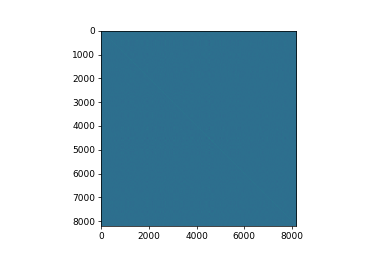

In [31]:
%matplotlib notebook

from basic_neural_processing_modules import similarity, decomposition

pairs = similarity.pairwise_similarity(latents.numpy())

plt.figure()
plt.imshow(pairs)

In [32]:
# dtp = decomposition.torch_pca(latents)[0]

# plt.figure()
# plt.plot(dtp)


In [33]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(latents)

PCA()

<IPython.core.display.Javascript object>


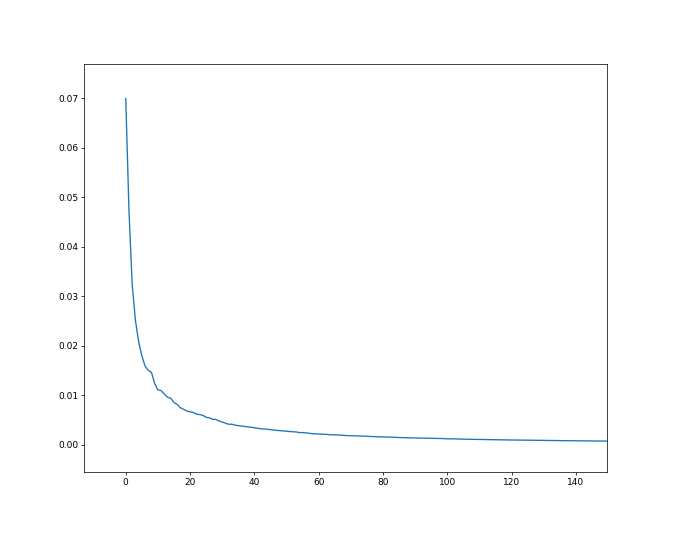

In [37]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.yscale('linear')

<IPython.core.display.Javascript object>


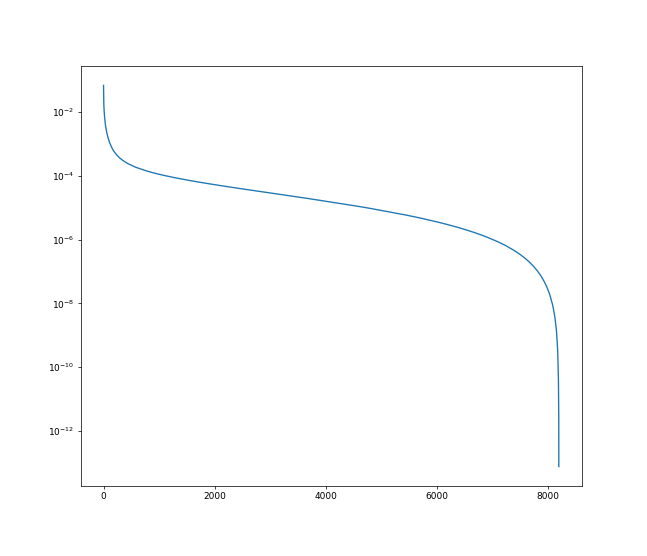

In [35]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')

In [36]:
import umap
# import sns
# sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
fit = umap.UMAP()
%time u = fit.fit_transform(latents)

CPU times: user 8min 57s, sys: 29.7 s, total: 9min 27s
Wall time: 58.9 s


In [38]:
import pandas as pd
xy_df = pd.DataFrame(u, columns=['x', 'y'])
xy_df['x_min'] = xy_df['x'].min()
xy_df['x_max'] = xy_df['x'].max()
xy_df['y_min'] = xy_df['y'].min()
xy_df['y_max'] = xy_df['y'].max()

xy_df['x_mm'] = (xy_df['x'] - xy_df['x_min']) / (xy_df['x_max'] - xy_df['x_min'])
xy_df['y_mm'] = (xy_df['y'] - xy_df['y_min']) / (xy_df['y_max'] - xy_df['y_min'])

xy_df['x_mmf'] = np.floor(xy_df['x_mm']*20)
xy_df['y_mmf'] = np.floor(xy_df['y_mm']*20)

xy_df['mmf'] = xy_df['x_mmf'].astype(str) + '_' + xy_df['y_mmf'].astype(str)
smpl_imgs = xy_df.groupby('mmf').sample(1)

In [39]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scl_to_bnd(x, bound_high):
    mx = x.max(axis=0, keepdims=True)
    mn = x.min(axis=0, keepdims=True)
    scl = (x - mn)*(bound_high-1)/(mx - mn)
    return scl, mn, mx

bound_high = 1000
bounded_features = scl_to_bnd(u, bound_high)
inx_lst = list(smpl_imgs.index)
img_lst = X_data[inx_lst]
x = bounded_features[0][inx_lst, 0]
y = bounded_features[0][inx_lst, 1]

In [40]:
def getImage(img):
    return OffsetImage(img, cmap='gray')

<IPython.core.display.Javascript object>


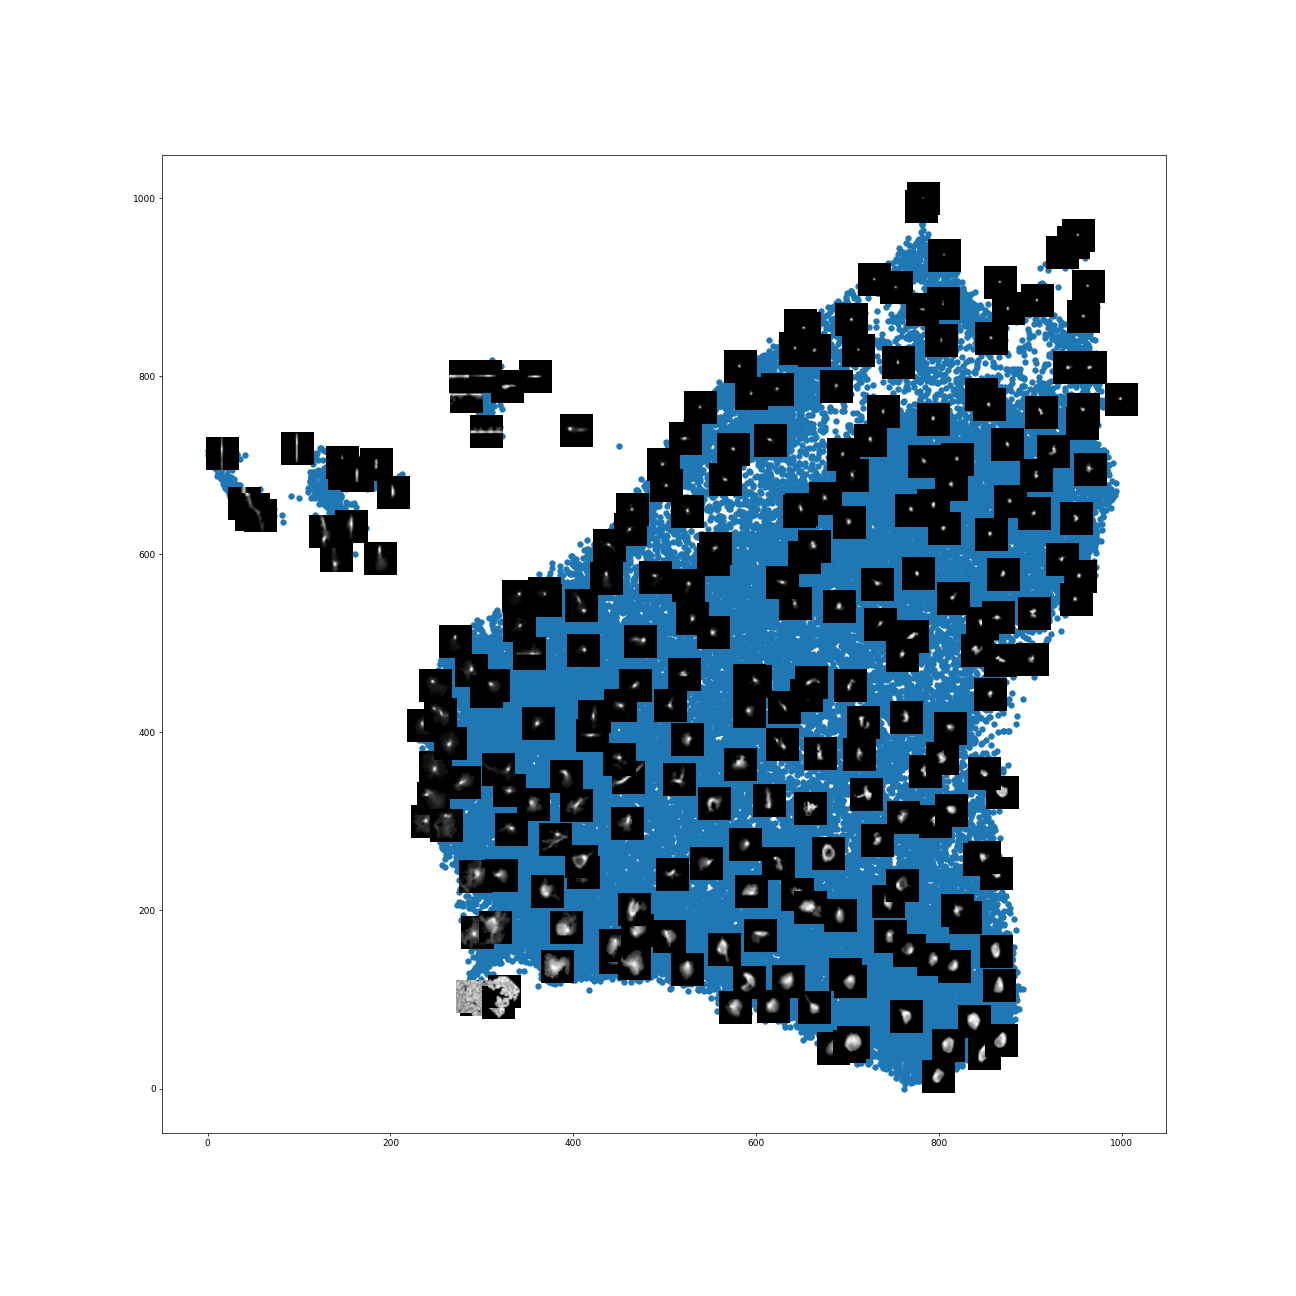

In [41]:
%matplotlib notebook
# plt.figure()
# plt.scatter(u[:,0], u[:,1])
# plt.title('UMAP');

fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(bounded_features[0][:,0], bounded_features[0][:,1], cmap=plt.get_cmap('tab10'))
ax.scatter(x, y)

for x0, y0, path in zip(x, y, img_lst):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

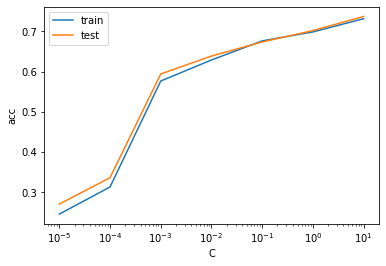

In [40]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


dataset_labeled_train = dataset_vicreg(
                                torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64)
dataset_labeled_val = dataset_vicreg(
                                torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                transforms=[scripted_transforms_validation, scripted_transforms_validation],
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
                                                    batch_size=800,
                                                    shuffle=False,
                                                    drop_last=False
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
                                                    batch_size=800,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    )


model.eval()
model.to(DEVICE)
features_train = torch.cat([model.projector(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_train)], dim=0)
features_val   = torch.cat([model.projector(model.backbone(data[0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_val)], dim=0)

torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
    logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
    acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
    acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

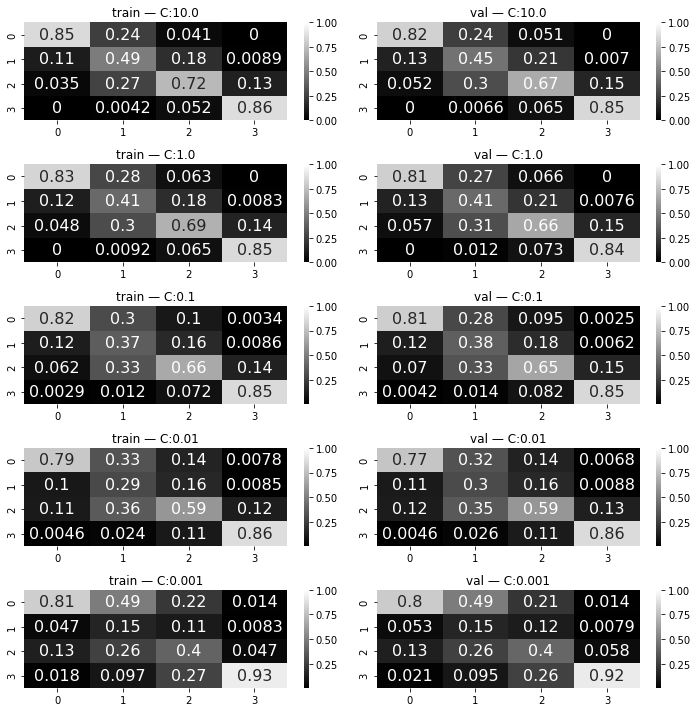

In [42]:
from sklearn.model_selection import ShuffleSplit
splitter = ShuffleSplit(n_splits=50)
all_split_inx = list(splitter.split(features_train))

train_X = [features_train[_[0]] for _ in all_split_inx]
train_y = [y_labeled_train[_[0]] for _ in all_split_inx]
# train_y = [y_labeled_train_SYT[_[0]] for _ in all_split_inx]
test_X = [features_train[_[1]] for _ in all_split_inx]
test_y = [y_labeled_train[_[1]] for _ in all_split_inx]
# test_y = [y_labeled_train_SYT[_[1]] for _ in all_split_inx]

%matplotlib inline

c_lst = [1e1, 1e0, 1e-1, 1e-2, 1e-3]

fig, ax = plt.subplots(len(c_lst), 2, figsize=(10,10))
# plt.suptitle(f'{model_file_name}')

for ic, c in enumerate(c_lst):
    train_cms = []
    test_cms = []
    for inx_split in trange(len(train_X)):
        tmp_train_X = train_X[inx_split]
        tmp_train_y = train_y[inx_split]
        
        tmp_test_X = test_X[inx_split]
        tmp_test_y = test_y[inx_split]
        
        logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=c).fit(tmp_train_X, tmp_train_y)
        
        
        
        
        
        proba = logreg.predict_proba(tmp_train_X)

        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_train_y)
        train_cms.append(cm)

#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('train');
        
        proba = logreg.predict_proba(tmp_test_X)
        preds = np.argmax(proba, axis=1)
        cm = classification.confusion_matrix(preds, tmp_test_y)
        test_cms.append(cm)
        
#         plt.figure()
#         sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#         plt.title('val');

    sns.heatmap(np.mean(train_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 0])
    ax[ic, 0].set_title(f'train — C:{c}');

    sns.heatmap(np.mean(test_cms,axis=0), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[ic, 1])
    ax[ic, 1].set_title(f'val — C:{c}');

plt.tight_layout()
plt.savefig(args.exp_dir / "latent512-w-projhead.png")

<function __main__.getImage(img)>

In [ ]:
break

In [ ]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

# base_model_frozen = torchvision.models.efficientnet_b0(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)


for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [ ]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [ ]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [ ]:
base_model_frozen

In [ ]:
# unfreeze particular blocks in ResNet model

# #efficient net 
# for name, param in list(model.named_parameters()):
#     print(name)
#     print(name)
#     if name[:10] == 'base_model':
#         if int(name[13]) < 7:
#             param.requires_grad = False
#         elif int(name[13]) >= 7:
#             param.requires_grad = True

# for name, param in list(model.named_parameters()):
#     if param.requires_grad:
#         print(name)


#ResNet18
for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if int(name[11]) < 7:
            param.requires_grad = False
        elif int(name[11]) >= 7:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

## Define augmentation pipeline

In [ ]:
# import torchvision.transforms    

# transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
#                                         scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
#                                         shear=(-15, 15, -15, 15),
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
#     augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
#                                     scaler_bounds=(10**(4), 10**(6)),
#                                     prob=1,
#                                     base=1000,
#                                     scaling='log'),
#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.00015,
#                                     prob=1),
    
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
#     # torchvision.transforms.Resize(size=(224,224), 
#     #                               interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
#     augmentation.TileChannels(dim=0, n_channels=3),
# )

import torchvision.transforms    

transforms = torch.nn.Sequential(
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
    augmentation.WarpPoints(r=[0, 1],
                            cx=[-0.5, 0.5],
                            cy=[-0.5, 0.5], 
                            dx=[-0.3, 0.0], 
                            dy=[-0.3, 0.0], 
                            n_warps=5,
                            prob=1.0,
                            img_size_in=[36, 36],
                            img_size_out=[224, 224]),

    
    augmentation.TileChannels(dim=0, n_channels=3),
#     torchvision.transforms.Resize(size=(224,224), 
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
)
    

scripted_transforms = torch.jit.script(transforms)


In [ ]:
dataset_train = dataset.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                # shuffle=True,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(1,2)
    # print(dataset_train[ii][0][0][0].shape)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [ ]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

## Training

In [ ]:
model.to(DEVICE)
model.prep_contrast()

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def get_ds_dl(data, transforms, expand_dim=False):
    setup_ds = dataset.dataset_simCLR(
                                    torch.as_tensor(data, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(data.shape[0]), device='cpu', dtype=torch.float32),


                                    n_transforms=1,
                                    transform=transforms,
                                    class_weights=np.array([1]),
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,

                                    temp_uncertainty=16,
                                    expand_dim=expand_dim
                                    )
    setup_dl = torch.utils.data.DataLoader( setup_ds,
                                            batch_size=1024,
                                            shuffle=False,
                                            drop_last=False,
                                            # pin_memory=True,
                                            # num_workers=16,
                                            # persistent_workers=True,
                                            )

    return setup_ds, setup_dl

In [ ]:
X_labeled_train.shape

In [ ]:
all_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)
no_transforms = torch.nn.Sequential(
)
scale_rsz_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
)
tile_transforms = torch.nn.Sequential(
    augmentation.TileChannels(dim=0, n_channels=3),
)


scripted_all_transforms = torch.jit.script(all_transforms)
scripted_no_transforms = torch.jit.script(no_transforms)
scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
scripted_tile_transform = torch.jit.script(tile_transforms)

In [ ]:
setup_transform = scripted_scale_rsz_transform
run_transform = scripted_tile_transform

setup_ds, setup_dl = get_ds_dl(X_labeled_train, setup_transform, expand_dim=True)
input_xtr = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=True)
input_xtr_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

setup_ds, setup_dl = get_ds_dl(X_labeled_val, setup_transform, expand_dim=True)
input_xval = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_val_SYT, setup_transform, expand_dim=True)
input_xval_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

# print("Starting!")
# tik = time.time()
# ds_run = util.dataset_simCLR(
#                             torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
#                             torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

#                             n_transforms=1,
#                             class_weights=np.array([1]),
#                             transform=run_transform,
#                             DEVICE='cpu',
#                             dtype_X=torch.float32,
#                             dtype_y=torch.int64,

#                             temp_uncertainty=16,
#                             expand_dim=False
#                             )
# dl_run = torch.utils.data.DataLoader( ds_run,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# tok = time.time()

# print(f'Tile Transformation Alone Took: {tok-tik} s to run')

In [ ]:
input_xtr.shape, input_xtr_SYT.shape, input_xval.shape, input_xval_SYT.shape

In [ ]:
# scale_rsz_transforms = torch.nn.Sequential(
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
#     torchvision.transforms.Resize(size=(224,224),
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR))
# tile_transforms = torch.nn.Sequential(augmentation.TileChannels(dim=0, n_channels=3),)


# scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
# scripted_tile_transform = torch.jit.script(tile_transforms)


# setup_transform = scripted_scale_rsz_transform
# run_transform = scripted_tile_transform



# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)

# setup_ds = util.dataset_simCLR(
#                                 torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
#                                 torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),
#                                 n_transforms=1,
#                                 transform=setup_transform,
#                                 class_weights=np.array([1]),
#                                 DEVICE='cpu',
#                                 dtype_X=torch.float32,
#                                 dtype_y=torch.int64,

#                                 temp_uncertainty=16,
#                                 expand_dim=False
#                                 )
# setup_dl = torch.utils.data.DataLoader( setup_ds,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )


# input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)
# # input_x_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)



In [ ]:
# acc_train_lst, acc_val_lst = [], []
# acc_train_SYT_lst, acc_val_SYT_lst = [], []

# print('A')
# ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
# features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)

# print('B')
# ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
# features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
# features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


# acc_train, acc_val = {}, {}
# acc_train_SYT, acc_val_SYT = {}, {}
# C_toUse = np.array([1e1,1e0,1e-1,1e-2])
# for C in C_toUse:
#     print('C1')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg.fit(features_train, y_labeled_train)
#     acc_train_tmp = logreg.score(features_train, y_labeled_train)
#     acc_train[C] = acc_train_tmp
#     acc_val_tmp = logreg.score(features_val, y_labeled_val)
#     acc_val[C] = acc_val_tmp
    
#     print('C2')
#     logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#     acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#     acc_train_SYT[C] = acc_train_tmp
#     acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#     acc_val_SYT[C] = acc_val_tmp

# acc_train_lst.append(acc_train)
# acc_val_lst.append(acc_val)
# acc_train_SYT_lst.append(acc_train_SYT)
# acc_val_SYT_lst.append(acc_val_SYT)


# losses_train_npy = np.array(losses_train)
# losses_val_npy = np.array(losses_val)
# val_accs_npy = np.array(val_accs)
# acc_npy = np.array(acc)

In [ ]:
# acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
# display(acc_train_df)
# display(acc_val_df)
# display(acc_train_SYT_df)
# display(acc_val_SYT_df)

# acc_train_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train.csv')
# acc_val_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val.csv')
# acc_train_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train_SYT.csv')
# acc_val_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val_SYT.csv')

In [ ]:
# model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient2-only7unfrozen'
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=cpu-reorg-test'
model.forward = model.forward_latent

In [ ]:
l2_alpha = 0.000
n_epochs=300000

acc_train_lst, acc_val_lst = [], []
acc_train_SYT_lst, acc_val_SYT_lst = [], []

for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    
    ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
    features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
    features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    
    ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
    features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
    features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


### Add back in for continuous evaluation of classification performance

#     acc_train, acc_val = {}, {}
#     acc_train_SYT, acc_val_SYT = {}, {}
#     C_toUse = np.array([1e1,1e0,1e-1,1e-2])
#     for C in C_toUse:
#         logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg.fit(features_train, y_labeled_train)
#         acc_train_tmp = logreg.score(features_train, y_labeled_train)
#         acc_train[C] = acc_train_tmp
#         acc_val_tmp = logreg.score(features_val, y_labeled_val)
#         acc_val[C] = acc_val_tmp
        
#         logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#         acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#         acc_train_SYT[C] = acc_train_tmp
#         acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#         acc_val_SYT[C] = acc_val_tmp

#     acc_train_lst.append(acc_train)
#     acc_val_lst.append(acc_val)
#     acc_train_SYT_lst.append(acc_train_SYT)
#     acc_val_SYT_lst.append(acc_val_SYT)

#     acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
    
#     acc_train_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train.csv')
#     acc_train_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train_SYT.csv')
#     acc_val_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val.csv')
#     acc_val_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val_SYT.csv')
    
    
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.5,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')
   
    # Add back in for continuous evaluation of classification performance

#     losses_train_npy = np.array(losses_train)
#     losses_val_npy = np.array(losses_val)
#     val_accs_npy = np.array(val_accs)
#     acc_npy = np.array(acc)
    
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_train.npy', losses_train_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_val.npy', losses_val_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_val_accs.npy', val_accs_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_tr_accs.npy', acc_npy)
    

In [ ]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [ ]:
torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')